In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

First we need to load the data from the Data Wrangling step.

In [3]:
demand = pd.read_csv("data/demand.csv", index_col=0)
forecast = pd.read_csv("data/forecast.csv", index_col=0)
netgen = pd.read_csv("data/netgen.csv", index_col=0)
demand.head()

,date,US48,CAL,CAR,CENT,FLA,MIDA,MIDW,NE,NY,...,SWPP,SPA,TEC,TVA,TEPC,TIDC,NSB,WALC,WACM,WAUW
0,2015-07-01 05:00:00+00:00,162827.0,0.0,22945.0,0.0,26384.0,84024.0,0.0,12583.0,16891.0,...,0.0,0.0,2541.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0
1,2015-07-01 06:00:00+00:00,335153.0,0.0,21396.0,28985.0,24336.0,79791.0,73432.0,12349.0,16027.0,...,28891.0,94.0,2367.0,16136.0,0.0,0.0,46.0,0.0,0.0,0.0
2,2015-07-01 07:00:00+00:00,333837.0,0.0,20627.0,27498.0,22842.0,76760.0,70211.0,12445.0,15541.0,...,27413.0,85.0,2246.0,15503.0,0.0,0.0,43.0,0.0,0.0,0.0
3,2015-07-01 08:00:00+00:00,398386.0,38210.0,20102.0,26384.0,21906.0,74931.0,68163.0,12385.0,15283.0,...,26291.0,93.0,2179.0,14896.0,1605.0,408.0,40.0,1119.0,0.0,0.0
4,2015-07-01 09:00:00+00:00,388954.0,35171.0,19931.0,25663.0,21615.0,74368.0,67309.0,12387.0,15304.0,...,25582.0,81.0,2157.0,14663.0,1537.0,380.0,38.0,1018.0,0.0,0.0


In [4]:
forecast.head()

,date,US48,CAL,CAR,CENT,FLA,MIDA,MIDW,NE,NY,...,SWPP,SPA,TEC,TVA,TEPC,TIDC,NSB,WALC,WACM,WAUW
0,2015-07-01 05:00:00+00:00,106573.0,0.0,24453.0,0.0,24781.0,29484.0,0.0,11810.0,16045.0,...,0.0,0.0,2250.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0
1,2015-07-01 06:00:00+00:00,269675.0,0.0,22731.0,28749.0,21203.0,27756.0,76958.0,11190.0,0.0,...,28673.0,76.0,2110.0,16349.0,0.0,0.0,39.0,0.0,0.0,0.0
2,2015-07-01 07:00:00+00:00,269773.0,0.0,21569.0,27243.0,20009.0,26643.0,74126.0,10860.0,0.0,...,27170.0,73.0,2010.0,15621.0,0.0,0.0,37.0,0.0,0.0,0.0
3,2015-07-01 08:00:00+00:00,331736.0,35264.0,20898.0,26120.0,19278.0,26098.0,72102.0,10760.0,0.0,...,26041.0,79.0,1950.0,15063.0,1471.0,410.0,37.0,1091.0,0.0,0.0
4,2015-07-01 09:00:00+00:00,324545.0,32894.0,20621.0,25451.0,19180.0,26289.0,71300.0,11200.0,0.0,...,25380.0,71.0,1970.0,14781.0,1418.0,380.0,38.0,1055.0,0.0,0.0


In [5]:
demand.iloc[24]

date    2015-07-02 05:00:00+00:00
US48                       453284
CAL                         44996
CAR                         23646
CENT                        31489
                  ...            
TIDC                          484
NSB                            47
WALC                         1102
WACM                            0
WAUW                            0
Name: 24, Length: 71, dtype: object

In [6]:
netgen.head()

,date,US48,CAL,CAR,CENT,FLA,MIDA,MIDW,NE,NY,...,SWPP,SPA,TEC,TVA,TEPC,TIDC,NSB,WALC,WACM,WAUW
0,2015-07-01 05:00:00+00:00,157438.0,0.0,22934.0,0.0,24794.0,83944.0,0.0,11322.0,14444.0,...,0.0,0.0,2794.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-07-01 06:00:00+00:00,328863.0,0.0,21397.0,29484.0,23033.0,80091.0,70103.0,11376.0,13809.0,...,28286.0,1198.0,2578.0,16196.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-07-01 07:00:00+00:00,326919.0,0.0,20598.0,28106.0,21663.0,77994.0,64905.0,11305.0,13435.0,...,26897.0,1209.0,2485.0,15496.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-07-01 08:00:00+00:00,380036.0,31005.0,20068.0,26841.0,20779.0,76820.0,62094.0,11303.0,13144.0,...,25632.0,1209.0,2417.0,15028.0,1599.0,234.0,0.0,1094.0,0.0,0.0
4,2015-07-01 09:00:00+00:00,371162.0,28760.0,19965.0,26174.0,20506.0,76268.0,60872.0,11460.0,13147.0,...,24964.0,1210.0,2385.0,14794.0,1471.0,223.0,0.0,890.0,0.0,0.0


Next we look at the clean and examine the forecast data creating some plots.

In [7]:
forecast = forecast.replace(to_replace = 0.0, value=np.NaN) 
forecast.isna().sum().describe()

count       71.000000
mean      1402.577465
std       3950.543665
min          0.000000
25%         46.000000
50%        192.000000
75%        658.000000
max      26011.000000
dtype: float64

We can evaluate the accuracy of the given forecast model. Since it is a forecast, it has more entries than the demand data frame, so we must correct for that. We can do this by dropping the last rows from the forecast data frame since the data is otherwise already aligned with the demand data frame.

In [8]:
diff = forecast.shape[0] - demand.shape[0] #there is more forecast data than actual demand data
sklearn.metrics.r2_score(demand['US48'], forecast['US48'].iloc[:-diff])

0.9509745723874736

<AxesSubplot:>

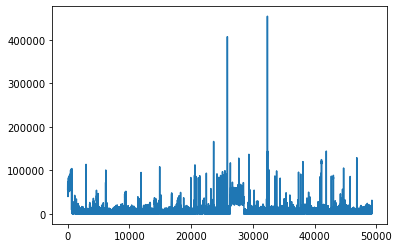

In [9]:
#Plot the difference
(demand['US48']-forecast['US48']).apply(abs).plot()

As we can see from the plot the error in the forecast is usually pretty low, but spikes up to 100,000 or more somewhat frequently. This is good as it means there is room for improvement if we can deal with these outliers.

In [10]:
#This function extracts date information and puts it in both raw and periodic formats
def extract_dates(X):
    dates = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    X['date'] = pd.to_datetime(X.date)
    X['month'] = X.date.apply(lambda x : x.month)
    X['year'] = X.date.apply(lambda x : x.year)
    X['dayOfMonth'] = X.date.apply(lambda x : x.day)
    X['dayOfWeek'] = X.date.apply(lambda x : x.isoweekday())
    X['hour'] = X.date.apply(lambda x : x.hour)
    X['month.p'] = 2*np.pi*X['month']/12.0
    X['daysInMonth'] = X.month.replace(dates)
    X['dayOfMonth.p'] = 2*np.pi*X['dayOfMonth']/X['daysInMonth']
    X['dayOfWeek.p'] = 2*np.pi*X['dayOfWeek']/7.0
    X['hour.p'] = 2*np.pi*X.hour/24.0
    return X

In [11]:
forecast = extract_dates(forecast)

<AxesSubplot:>

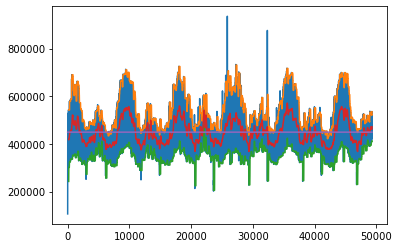

In [17]:
#plt.xticks(forecast['date'])
forecast['US48'].plot()
days = 7
forecast['US48'].rolling(days*24).quantile(0.995).plot()
forecast['US48'].rolling(days*24).quantile(0.005).plot()
forecast['US48'].rolling(days*24).mean().plot()
forecast['AVG'] = forecast['US48'].mean()
forecast['AVG'].plot()

<AxesSubplot:>

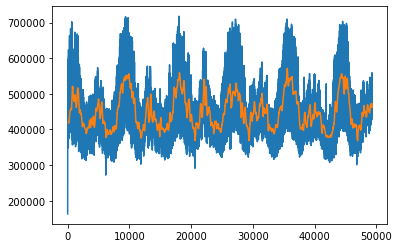

In [18]:
roll = forecast['US48'].rolling(days*24).mean()
sklearn.metrics.r2_score(demand['US48'].iloc[167-11:49297],roll.iloc[167:49297])
demand['US48'].plot()
roll.plot()

In [19]:
def sin_cos(index, fourier):
    mags  = list(map(lambda z: z.real, fourier))
    freqs = list(map(lambda z: z.imag, fourier))
    result = 0
    for i in range(len(fourier)):
        result = result + mags[i]*(np.cos(freqs[i]*i) + np.sin(freqs[i]*i))
    return result

<AxesSubplot:>

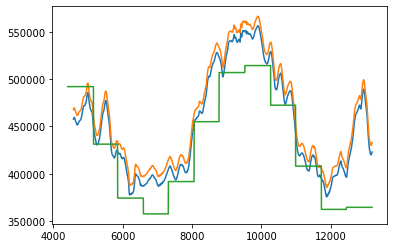

In [20]:
tyear = 2016
forecast[forecast['year']==tyear]['US48'].rolling(days*24).mean().plot()
fourier =((np.fft.ifft(np.fft.fft(forecast[forecast['year']==tyear]['US48']))))
#print(list(map(lambda i: sin_cos(i, fourier[:1000]), forecast[forecast['year']==tyear].index)))
#print(max(fourier.real))
plt.plot((forecast[forecast['year']==tyear]['US48']).index, pd.Series(fourier).rolling(days*24).mean()+10000)
#I did have these two variables just calculated inline, but that took a really long time
med = forecast[forecast['year']==tyear]['US48'].quantile(0.5)
std = forecast[forecast['year']==tyear]['US48'].std()

#I played around with this to try and get a good manual fit with the period.
forecast[forecast['year']==tyear]['month.p'].apply(
    lambda x: med + std * np.sin(np.pi/2*x+np.pi/2)).plot()

<AxesSubplot:>

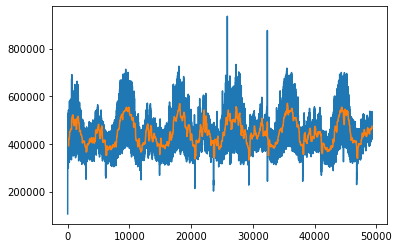

In [21]:
forecast['US48'].plot()
((forecast['US48'].rolling(days*24).quantile(0.995)+forecast['US48'].rolling(days*24).quantile(0.005))/2).plot()
#forecast['US48'].rolling(days*24).mean().plot()

In [22]:
forecast.shape

(49300, 82)

In [23]:
diff = forecast.shape[0] - demand.shape[0]

In [24]:
diff

14

In [25]:
forecast.iloc[86:].shape

(49214, 82)

In [26]:
sklearn.metrics.r2_score(demand['US48'], forecast['US48'].iloc[:-diff])

0.9509745723874736

In [27]:
mean_squared_error(demand['US48'], forecast['US48'].iloc[:-diff])

277811653.22754943

In [28]:
d = pd.DataFrame()
(demand['CAL'].iat[4]==0).sum()

0

In [29]:
for column in demand.columns:
    for i in range(len(demand[column])):
        d[column] = demand[column]
        if (d[column].iloc[:i]==0).sum() == i:
            d[column].iloc[:i] = np.NAN
        else: 
            break
d.head()

,date,US48,CAL,CAR,CENT,FLA,MIDA,MIDW,NE,NY,...,SWPP,SPA,TEC,TVA,TEPC,TIDC,NSB,WALC,WACM,WAUW
0,2015-07-01 05:00:00+00:00,162827.0,0.0,22945.0,0.0,26384.0,84024.0,0.0,12583.0,16891.0,...,0.0,0.0,2541.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0
1,2015-07-01 06:00:00+00:00,335153.0,0.0,21396.0,28985.0,24336.0,79791.0,73432.0,12349.0,16027.0,...,28891.0,94.0,2367.0,16136.0,0.0,0.0,46.0,0.0,0.0,0.0
2,2015-07-01 07:00:00+00:00,333837.0,0.0,20627.0,27498.0,22842.0,76760.0,70211.0,12445.0,15541.0,...,27413.0,85.0,2246.0,15503.0,0.0,0.0,43.0,0.0,0.0,0.0
3,2015-07-01 08:00:00+00:00,398386.0,38210.0,20102.0,26384.0,21906.0,74931.0,68163.0,12385.0,15283.0,...,26291.0,93.0,2179.0,14896.0,1605.0,408.0,40.0,1119.0,0.0,0.0
4,2015-07-01 09:00:00+00:00,388954.0,35171.0,19931.0,25663.0,21615.0,74368.0,67309.0,12387.0,15304.0,...,25582.0,81.0,2157.0,14663.0,1537.0,380.0,38.0,1018.0,0.0,0.0


Here we create time shifted versions of select features for analysis

In [30]:
us_demand = demand[['date', 'US48']]
for i in [1,2,3,12,24,48,72]:
    us_demand['US48.H' + str(i)] = us_demand['US48'].shift(i)
us_demand = us_demand.iloc[72:]

In [31]:
us_demand.head()

,date,US48,US48.H1,US48.H2,US48.H3,US48.H12,US48.H24,US48.H48,US48.H72
72,2015-07-04 05:00:00+00:00,428928.0,455366.0,482726.0,500554.0,487268.0,440084.0,453284.0,162827.0
73,2015-07-04 06:00:00+00:00,403685.0,428928.0,455366.0,482726.0,504422.0,415203.0,429199.0,335153.0
74,2015-07-04 07:00:00+00:00,384331.0,403685.0,428928.0,455366.0,518545.0,394227.0,407007.0,333837.0
75,2015-07-04 08:00:00+00:00,373639.0,384331.0,403685.0,428928.0,528781.0,383147.0,395194.0,398386.0
76,2015-07-04 09:00:00+00:00,363002.0,373639.0,384331.0,403685.0,536381.0,373941.0,387654.0,388954.0


In [32]:
us_demand['US48.(H2-H1)'] = us_demand['US48.H2']- us_demand['US48.H1']
us_demand['US48.(H3-H2)'] = us_demand['US48.H3']- us_demand['US48.H2']
us_demand['US48.(H48-H24)'] = us_demand['US48.H48']- us_demand['US48.H24']
us_demand['US48.(H72-H48)'] = us_demand['US48.H72']- us_demand['US48.H48']

In [33]:
us_demand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49214 entries, 72 to 49285
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            49214 non-null  object 
 1   US48            49214 non-null  float64
 2   US48.H1         49214 non-null  float64
 3   US48.H2         49214 non-null  float64
 4   US48.H3         49214 non-null  float64
 5   US48.H12        49214 non-null  float64
 6   US48.H24        49214 non-null  float64
 7   US48.H48        49214 non-null  float64
 8   US48.H72        49214 non-null  float64
 9   US48.(H2-H1)    49214 non-null  float64
 10  US48.(H3-H2)    49214 non-null  float64
 11  US48.(H48-H24)  49214 non-null  float64
 12  US48.(H72-H48)  49214 non-null  float64
dtypes: float64(12), object(1)
memory usage: 5.3+ MB


Now prep for training models.

In [34]:
X = us_demand.drop(['US48'], axis=1)
y = us_demand['US48']
tscv = TimeSeriesSplit(n_splits=10)


In [35]:
tscv
cv_results = sklearn.model_selection.cross_val_score(linear_model.LinearRegression(), X.iloc[:30000], y[:30000], cv=tscv, scoring='r2')

In [36]:
cv_results

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [37]:
model = linear_model.LinearRegression()
X['date'] = pd.to_datetime(X.date)
X['month'] = X.date.apply(lambda x : x.month)
X['year'] = X.date.apply(lambda x : x.year)
X['dayOfMonth'] = X.date.apply(lambda x : x.day)
X['dayOfWeek'] = X.date.apply(lambda x : x.isoweekday())
X['hour'] = X.date.apply(lambda x : x.hour)

In [38]:
X.head()

,date,US48.H1,US48.H2,US48.H3,US48.H12,US48.H24,US48.H48,US48.H72,US48.(H2-H1),US48.(H3-H2),US48.(H48-H24),US48.(H72-H48),month,year,dayOfMonth,dayOfWeek,hour
72,2015-07-04 05:00:00+00:00,455366.0,482726.0,500554.0,487268.0,440084.0,453284.0,162827.0,27360.0,17828.0,13200.0,-290457.0,7,2015,4,6,5
73,2015-07-04 06:00:00+00:00,428928.0,455366.0,482726.0,504422.0,415203.0,429199.0,335153.0,26438.0,27360.0,13996.0,-94046.0,7,2015,4,6,6
74,2015-07-04 07:00:00+00:00,403685.0,428928.0,455366.0,518545.0,394227.0,407007.0,333837.0,25243.0,26438.0,12780.0,-73170.0,7,2015,4,6,7
75,2015-07-04 08:00:00+00:00,384331.0,403685.0,428928.0,528781.0,383147.0,395194.0,398386.0,19354.0,25243.0,12047.0,3192.0,7,2015,4,6,8
76,2015-07-04 09:00:00+00:00,373639.0,384331.0,403685.0,536381.0,373941.0,387654.0,388954.0,10692.0,19354.0,13713.0,1300.0,7,2015,4,6,9


In [39]:
model.fit(pd.DataFrame(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']].iloc[:10000]),pd.DataFrame(y.iloc[:10000]))
model2 = linear_model.LinearRegression()
model2.fit(pd.DataFrame(X[['US48.H24']].iloc[:10000]),pd.DataFrame(y.iloc[:10000]))

LinearRegression()

In [40]:
model.score(pd.DataFrame(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']].iloc[10000:]), pd.DataFrame(y.iloc[10000:]))

0.9268866378364472

In [107]:
X.head()

,date,US48.H1,US48.H2,US48.H3,US48.H12,US48.H24,US48.H48,US48.H72,US48.(H2-H1),US48.(H3-H2),US48.(H48-H24),US48.(H72-H48),month,year,dayOfMonth,dayOfWeek,hour
72,2015-07-04 05:00:00+00:00,455366.0,482726.0,500554.0,487268.0,440084.0,453284.0,162827.0,27360.0,17828.0,13200.0,-290457.0,7,2015,4,6,5
73,2015-07-04 06:00:00+00:00,428928.0,455366.0,482726.0,504422.0,415203.0,429199.0,335153.0,26438.0,27360.0,13996.0,-94046.0,7,2015,4,6,6
74,2015-07-04 07:00:00+00:00,403685.0,428928.0,455366.0,518545.0,394227.0,407007.0,333837.0,25243.0,26438.0,12780.0,-73170.0,7,2015,4,6,7
75,2015-07-04 08:00:00+00:00,384331.0,403685.0,428928.0,528781.0,383147.0,395194.0,398386.0,19354.0,25243.0,12047.0,3192.0,7,2015,4,6,8
76,2015-07-04 09:00:00+00:00,373639.0,384331.0,403685.0,536381.0,373941.0,387654.0,388954.0,10692.0,19354.0,13713.0,1300.0,7,2015,4,6,9


In [108]:
mean_squared_error(pd.DataFrame(y.iloc[30000:]), model.predict(pd.DataFrame(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']].iloc[30000:])))

363977083.505702

In [109]:
mean_squared_error(pd.DataFrame(y.iloc[30000:]), model.predict(pd.DataFrame(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']].iloc[30000:])))

363977083.505702

In [110]:
#percent ERROR

In [111]:
mean_absolute_error(pd.DataFrame(y.iloc[30000:]), model.predict(pd.DataFrame(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']].iloc[30000:])))/y.max()

0.020892589971538186

In [112]:
X.date

72      2015-07-04 05:00:00+00:00
73      2015-07-04 06:00:00+00:00
74      2015-07-04 07:00:00+00:00
75      2015-07-04 08:00:00+00:00
76      2015-07-04 09:00:00+00:00
                   ...           
49281   2021-02-12 14:00:00+00:00
49282   2021-02-12 15:00:00+00:00
49283   2021-02-12 16:00:00+00:00
49284   2021-02-12 17:00:00+00:00
49285   2021-02-12 18:00:00+00:00
Name: date, Length: 49214, dtype: datetime64[ns, UTC]

In [113]:
def mae(actual, pred):
    return (actual-pred).apply(abs).max()

In [114]:
mae(pd.DataFrame(y.iloc[30000:]), model.predict(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']].iloc[30000:]))

US48    145640.568302
dtype: float64

In [115]:
from sklearn.gaussian_process import GaussianProcessRegressor
gpr = GaussianProcessRegressor()

In [116]:
gpr.fit(pd.DataFrame(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']].iloc[:10000]),pd.DataFrame(y.iloc[:10000]))

GaussianProcessRegressor()

In [117]:
gpr.score(pd.DataFrame(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']].iloc[10000:]),pd.DataFrame(y.iloc[10000:]))

-38.3404811313615

In [118]:
from sklearn.ensemble import RandomForestRegressor

In [119]:
rfr = RandomForestRegressor()
rfr.fit(pd.DataFrame(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']].iloc[:10000]),pd.DataFrame(y.iloc[:10000]))

RandomForestRegressor()

In [120]:
rfr.score(pd.DataFrame(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']].iloc[10000:]),pd.DataFrame(y.iloc[10000:]))

0.9465029986374449

In [121]:
dtr = DecisionTreeRegressor()

In [122]:
dtr.fit(pd.DataFrame(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']].iloc[:10000]),pd.DataFrame(y.iloc[:10000]))

DecisionTreeRegressor()

In [123]:
dtr.score(pd.DataFrame(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']].iloc[30000:]),pd.DataFrame(y.iloc[30000:]))

0.910206120959909

#### We need to evaluate the predictions we have from the EIA forecast to see how these models compare

In [124]:
forecast.shape

(49300, 82)

In [125]:
diff = forecast.shape[0] - X.shape[0]

In [126]:
diff

86

In [127]:
forecast.iloc[86:].shape

(49214, 82)

In [128]:
y_F = forecast.iloc[72:-14].US48
f = y_F.iloc[:-3] == 0
f.apply(int).sum()
#y_F.fillna(0, inplace=True)

0

In [129]:
sklearn.metrics.r2_score(y[:], y_F[:])

0.9516541315775342

In [130]:
mae(y[:], y_F[:])

453985.0

In [131]:
mean_squared_error(y, y_F)

273886702.7563701

Grid search for a random forest regressor.

In [132]:
params = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=rfr, cv=tscv, param_grid=params, scoring = sklearn.metrics.make_scorer(sklearn.metrics.r2_score))
gsearch.fit(pd.DataFrame(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']]),y)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [133]:
best_score

0.9458187475684822

Here is a plot of the best model from the grid search vs. the actual demand.

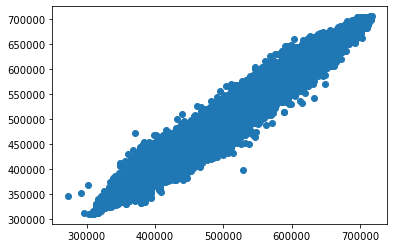

In [137]:
plt.scatter(y, best_model.predict(X[['US48.H24', 'year', 'month', 'dayOfMonth', 'dayOfWeek', 'hour']]))